# sentences(1).json Exploration

## Introduction

The next notebook is an exploration of the 'sentences(1).json'. The goal of this notebook is to understand deeply the data and also to review the methods used for that purpose. The notebook is not intended to be a very difficult implentation of methods, but a simple and deep explanation and comprehension of each method used. For this purpose, the next steps will be followed:

* Text statistics Analysis
* N-Gram Exploration and Knowledge graphs
* Topic Classification

In [2]:
import json
with open('sentences (1).json','r') as file:
    sentences = json.load(file)
print(sentences)

["The dragonfly's wings sparkled like gemstones in the sunlight.", 'The bagpipes were adorned with a tartan pattern, honoring Scottish tradition.', 'The fur pattern on the tiger was striking and intimidating.', 'The triangle was simple but required precise timing.', 'The sequoia tree was so tall it seemed to touch the sky.', 'The microchip was so small it could be embedded under the skin.', 'The mimosa plant responded to touch by folding its leaves.', 'The porcupine had quills that could detach when threatened.', 'The dandelion seed head formed a delicate sphere, ready to be carried away by the wind.', 'The origami crane was minute but intricately folded.', 'The didgeridoo produced a haunting sound that was deeply rooted in Aboriginal culture.', 'The virtual reality headset offered an immersive experience.', 'The petals of the rose were arranged in perfect symmetry.', 'The pickup truck had a toolbox and a rack for carrying lumber.', "The dolphin's streamlined shape made it look gracefu

## Exploratory Data Analysis (EDA)

C:\Users\pablo\AppData\Local\Temp\ipykernel_13820\486062947.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_words.values, y=top_words.index, palette="viridis")
C:\Users\pablo\AppData\Roaming\Python\Python311\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\pablo\AppData\Roaming\Python\Python311\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\pablo\AppData

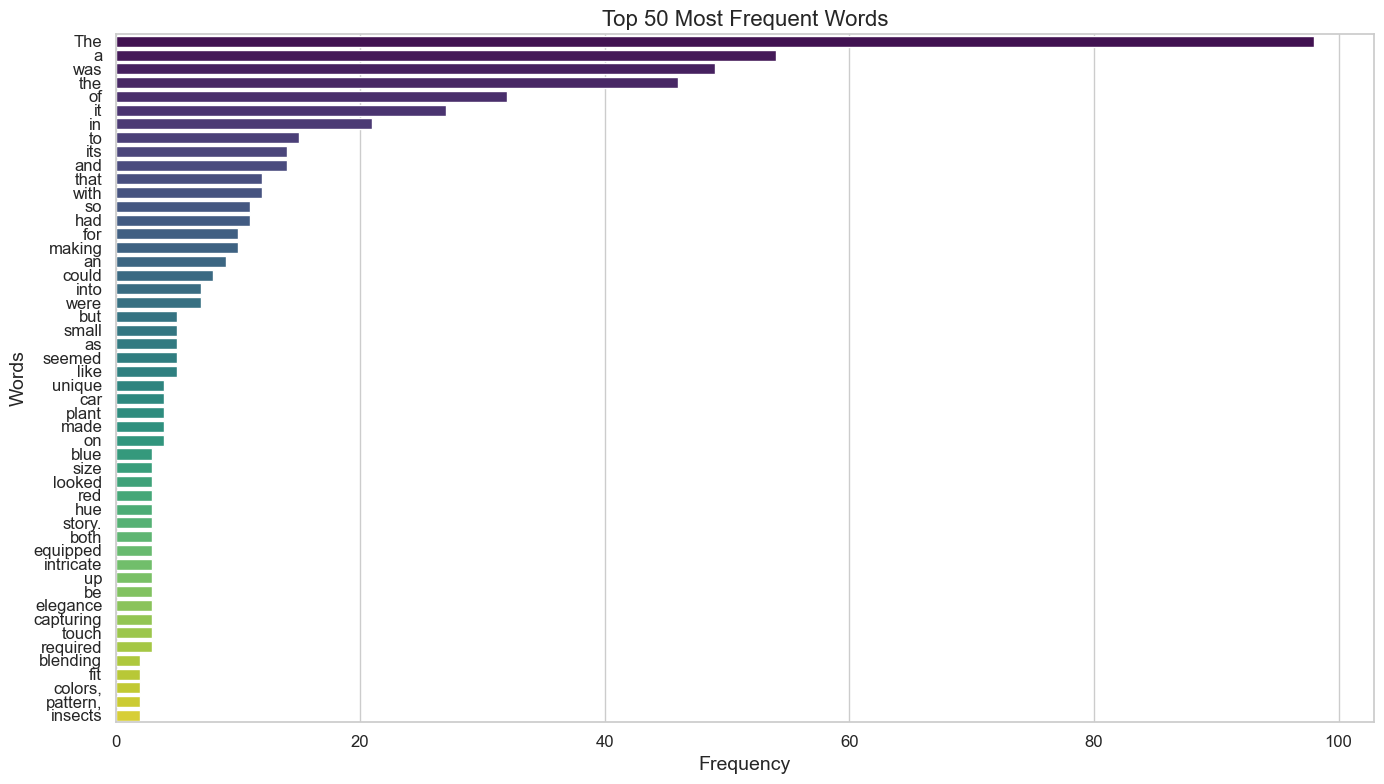

In [3]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

df = pd.DataFrame(sentences, columns=['sentence'])

all_words = df['sentence'].str.split(expand=True).stack().value_counts()

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Top 50 bar plot of uncleaned words
plt.figure(figsize=(14, 8))
top_words = all_words.head(50)
sns.barplot(x=top_words.values, y=top_words.index, palette="viridis")

plt.title('Top 50 Most Frequent Words', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Words', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

We are going to create some knowledge graph in order to understand the data better.

In [ ]:
import re
import requests
import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_sm")

from spacy.matcher import Matcher
from spacy.tokens import Span

import networkx as nx
from tqdm import tqdm

In [5]:
# Function to extract subject and object relations from sentences
def get_entities(sent):
    ## Chunk 1
    ent1 = "" # Subject
    ent2 = "" # Object
    
    prv_tok_dep = ""    # Dependency tag of previous token in the sentence
    prv_tok_text = ""   # Previous token in the sentence
    
    prefix = "" # Prefix of the dependency tag
    modifier = "" # Modifier of the dependency tag
    
    for tok in nlp(sent):
        ## Chunk 2
        # Check if token is a punctuation mark, if yes, ignore it
        if tok.dep_ != "punct":
            # Check if token is a compound word
            if tok.dep_ == "compound":
                prefix = tok.text
                # If the previous word was also a 'compound' word, add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " "+ tok.text
        
            # Check if token is a modifier
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # If the previous word was also a 'compound' word, add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " "+ tok.text
            
            ## Chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier +" "+ prefix + " "+ tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""
            
            ## Chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = modifier +" "+ prefix +" "+ tok.text
            
            ## Chunk 5
            # Update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
            
    return [ent1.strip(), ent2.strip()]


In [6]:
# Check how it works
doc = sentences[2]
for tok in nlp(doc):
    print(tok.text, "-->",tok.dep_)
print(sentences[2])
print(get_entities(sentences[2]))

The --> det
fur --> compound
pattern --> nsubj
on --> prep
the --> det
tiger --> pobj
was --> aux
striking --> ROOT
and --> cc
intimidating --> conj
. --> punct
The fur pattern on the tiger was striking and intimidating.
['fur pattern', 'tiger']


In [7]:
# Now we can extract this entities from all the data
entity_pairs = []

for i in tqdm(sentences):
    entity_pairs.append(get_entities(i))

100%|██████████| 100/100 [00:00<00:00, 191.85it/s]


The pattern defined in the function tries to find the ROOT word or the main verb in the sentence. Once the ROOT is identified, then the pattern checks whether it is followed by a preposition (‘prep’) or an agent word. If yes, then it is added to the ROOT word

In [8]:
# Now we are going to extract the relationship (predicate), following the spaCy rule-based matching. 

def get_relation(sent):
    
    doc = nlp(sent)
    
    # matcher class object
    matcher = Matcher(nlp.vocab) # Matcher class object is used to match token patterns like regular expressions
    
    pattern = [{'DEP':'ROOT'},
                {'DEP':'prep','OP':"?"},
                {'DEP':'agent','OP':"?"},  # agent is a noun phrase
                {'POS':'ADJ','OP':"?"}]
    
    matcher.add("matching_1", [pattern])
    
    matches = matcher(doc)
    k = len(matches) - 1
    
    span = doc[matches[k][1]:matches[k][2]] # Extract the matched part
    
    return(span.text)
    
    

In [9]:
doc = sentences[2]
for tok in nlp(doc):
    print(tok.text, "-->",tok.dep_)
print(sentences[2])
print(get_entities(sentences[2]))
print(get_relation(sentences[2]))

The --> det
fur --> compound
pattern --> nsubj
on --> prep
the --> det
tiger --> pobj
was --> aux
striking --> ROOT
and --> cc
intimidating --> conj
. --> punct
The fur pattern on the tiger was striking and intimidating.
['fur pattern', 'tiger']
striking


In [10]:
relations = [get_relation(i) for i in tqdm(sentences)]
pd.Series(relations).value_counts()[:50]

100%|██████████| 100/100 [00:00<00:00, 184.96it/s]


was                          18
had                           8
were                          4
made                          4
equipped with                 2
was small                     2
formed                        2
displayed                     2
seemed                        2
sparkled like                 1
changed                       1
feathers of                   1
maintained                    1
was enormous                  1
was capable                   1
covered                       1
done in                       1
was silver                    1
customized with elaborate     1
crafted from                  1
cherished for                 1
telling                       1
was sleek                     1
curl                          1
had aerodynamic               1
appeared bizarre              1
lit                           1
served as                     1
was elegant                   1
was tiny                      1
carved                        1
created 

In [11]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

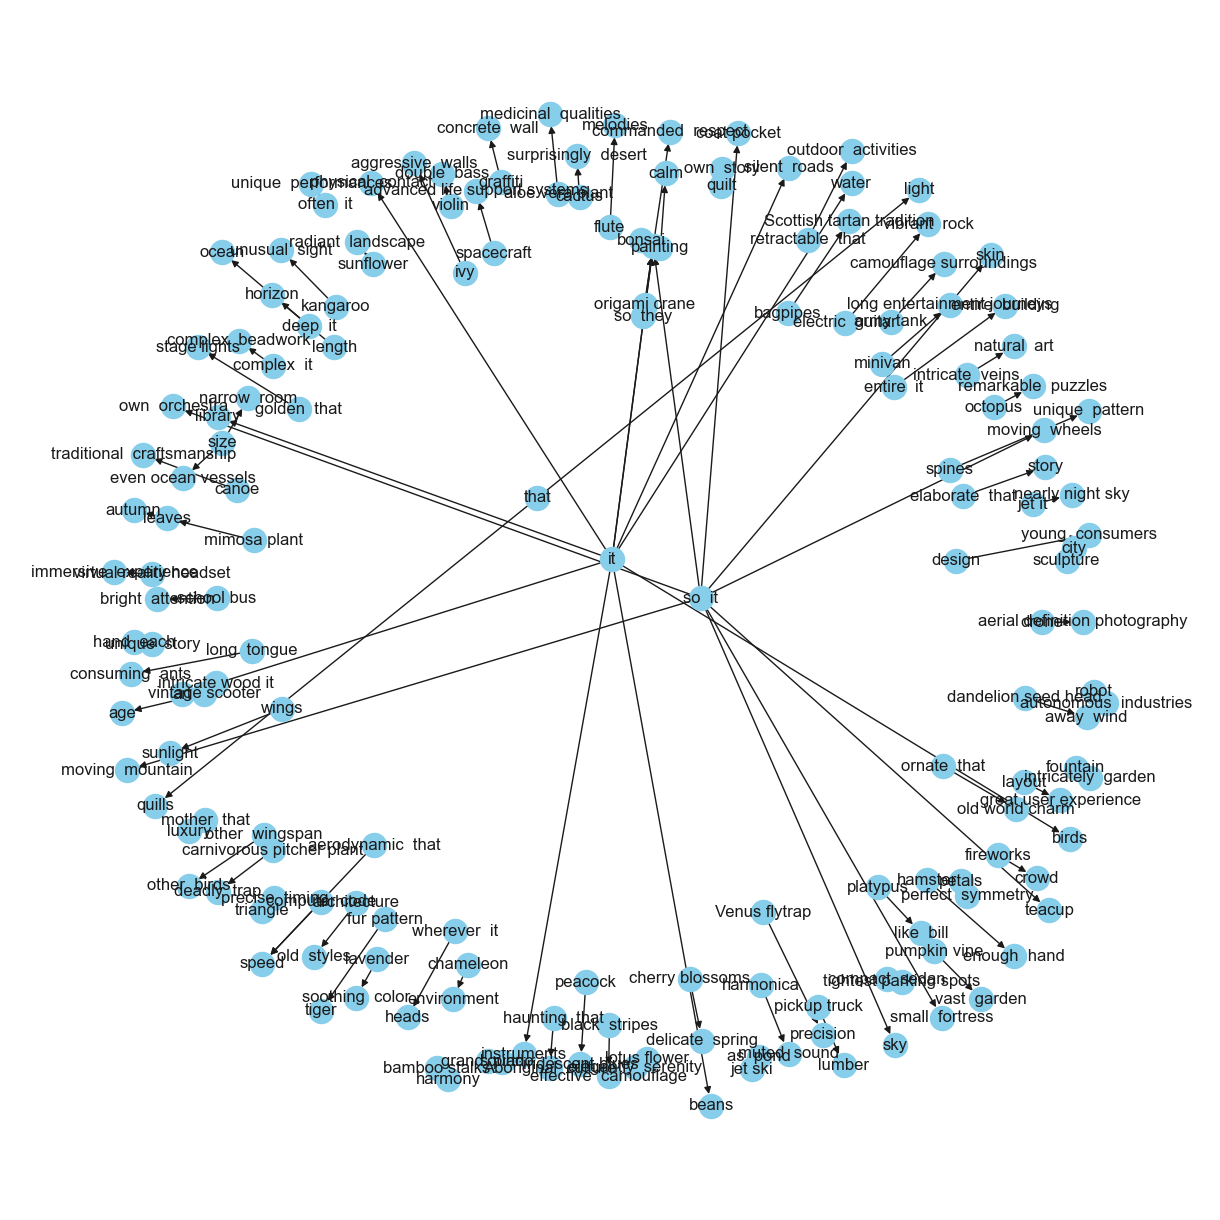

In [12]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
                          
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

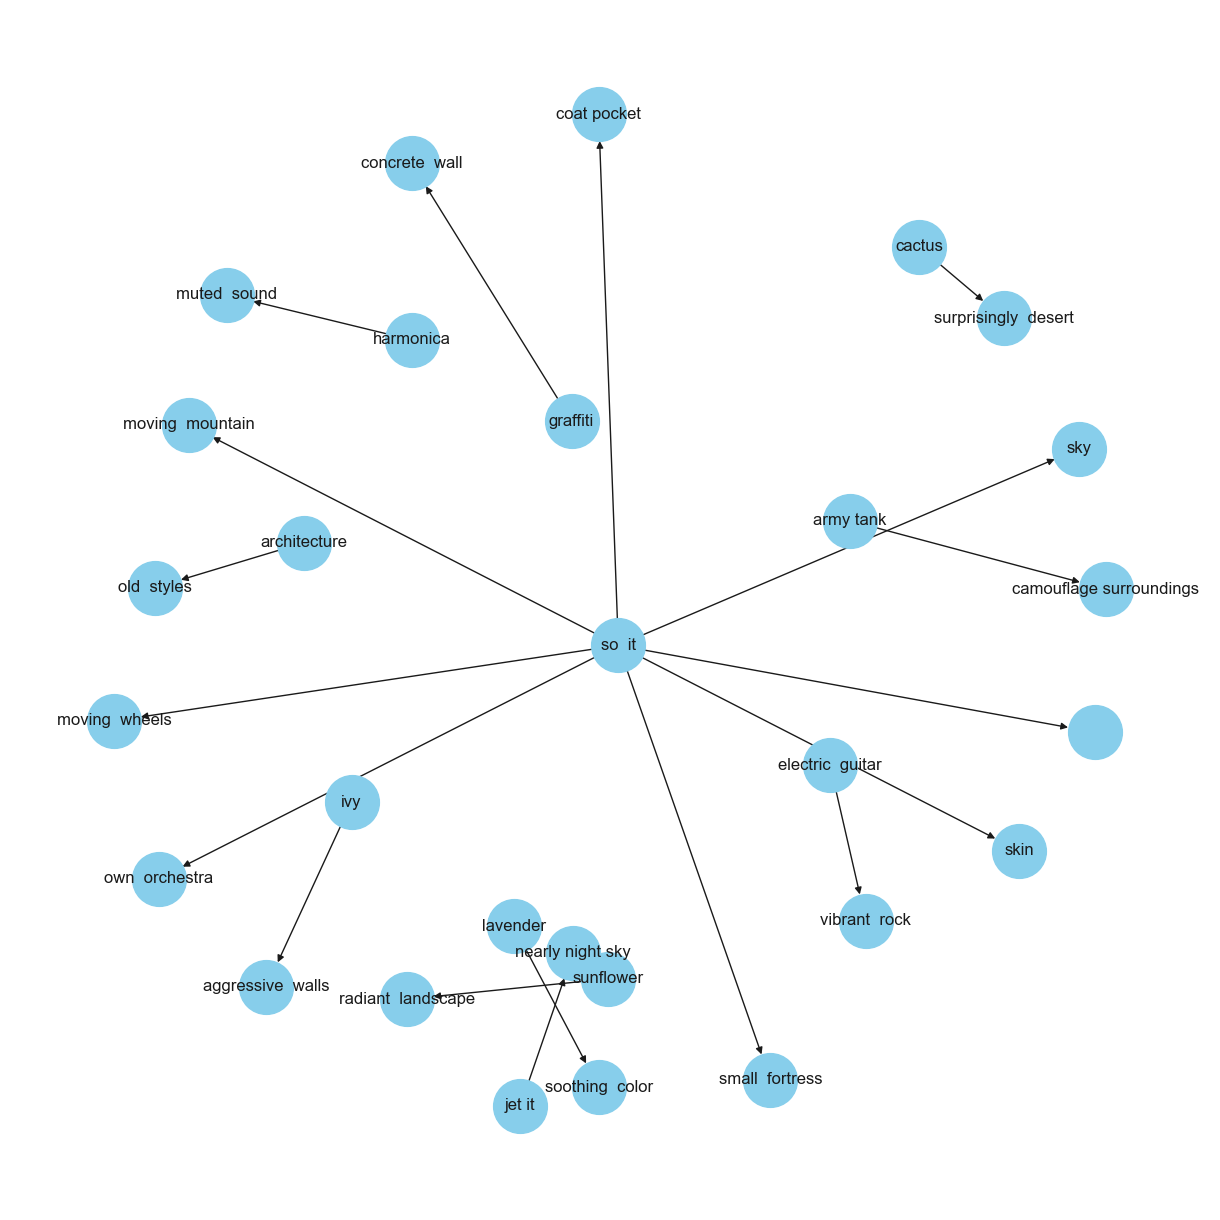

In [13]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="was"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

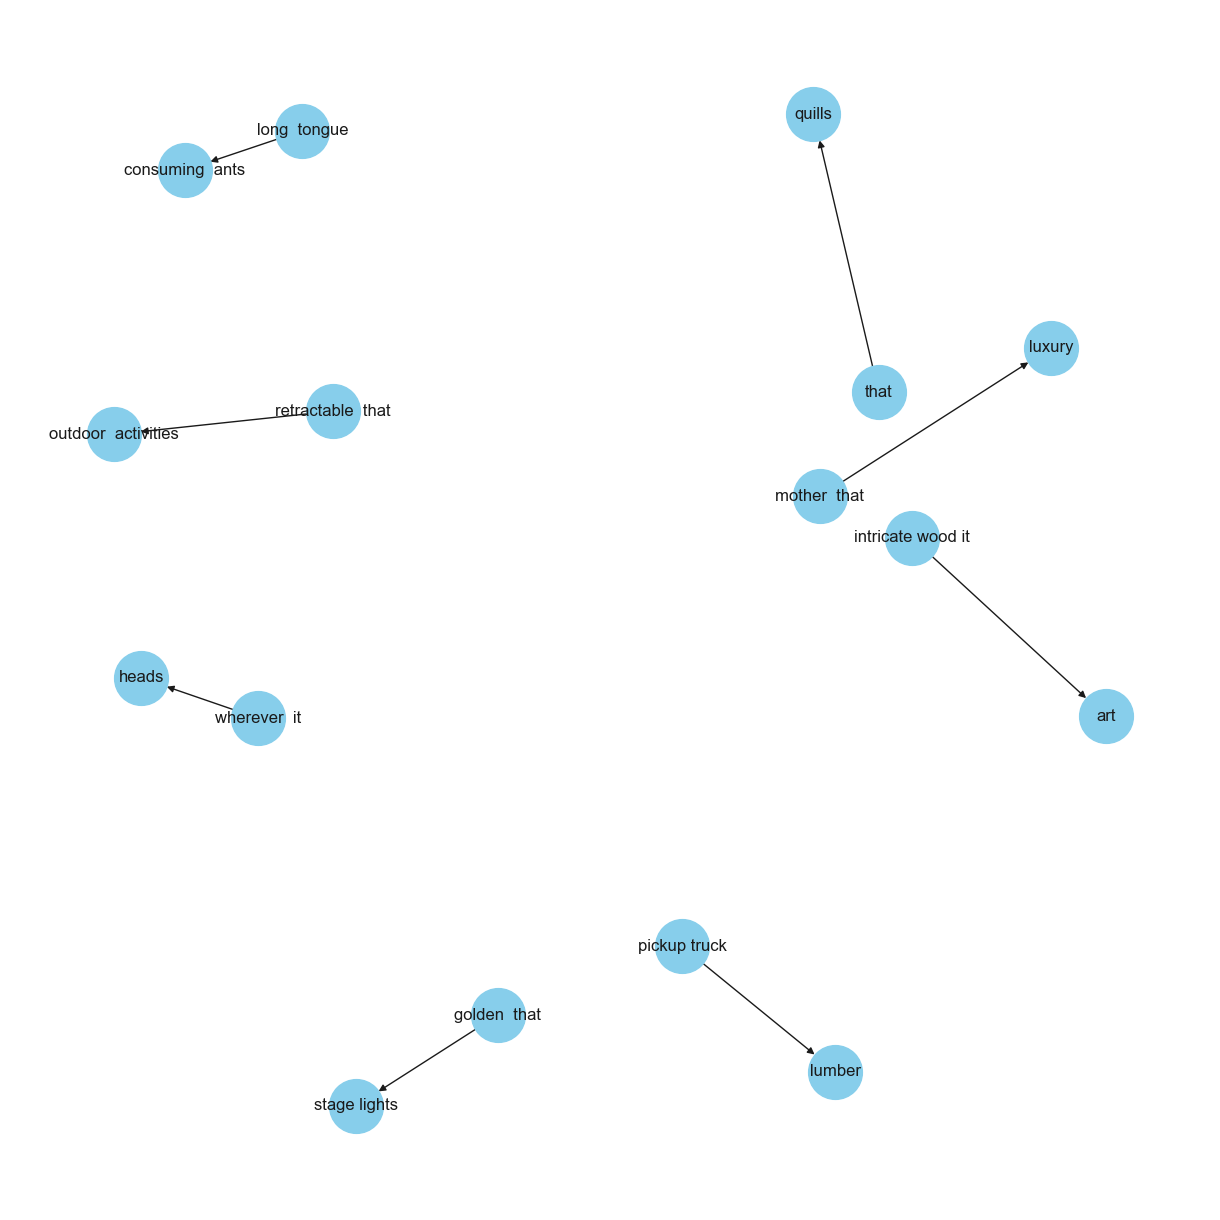

In [14]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="had"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

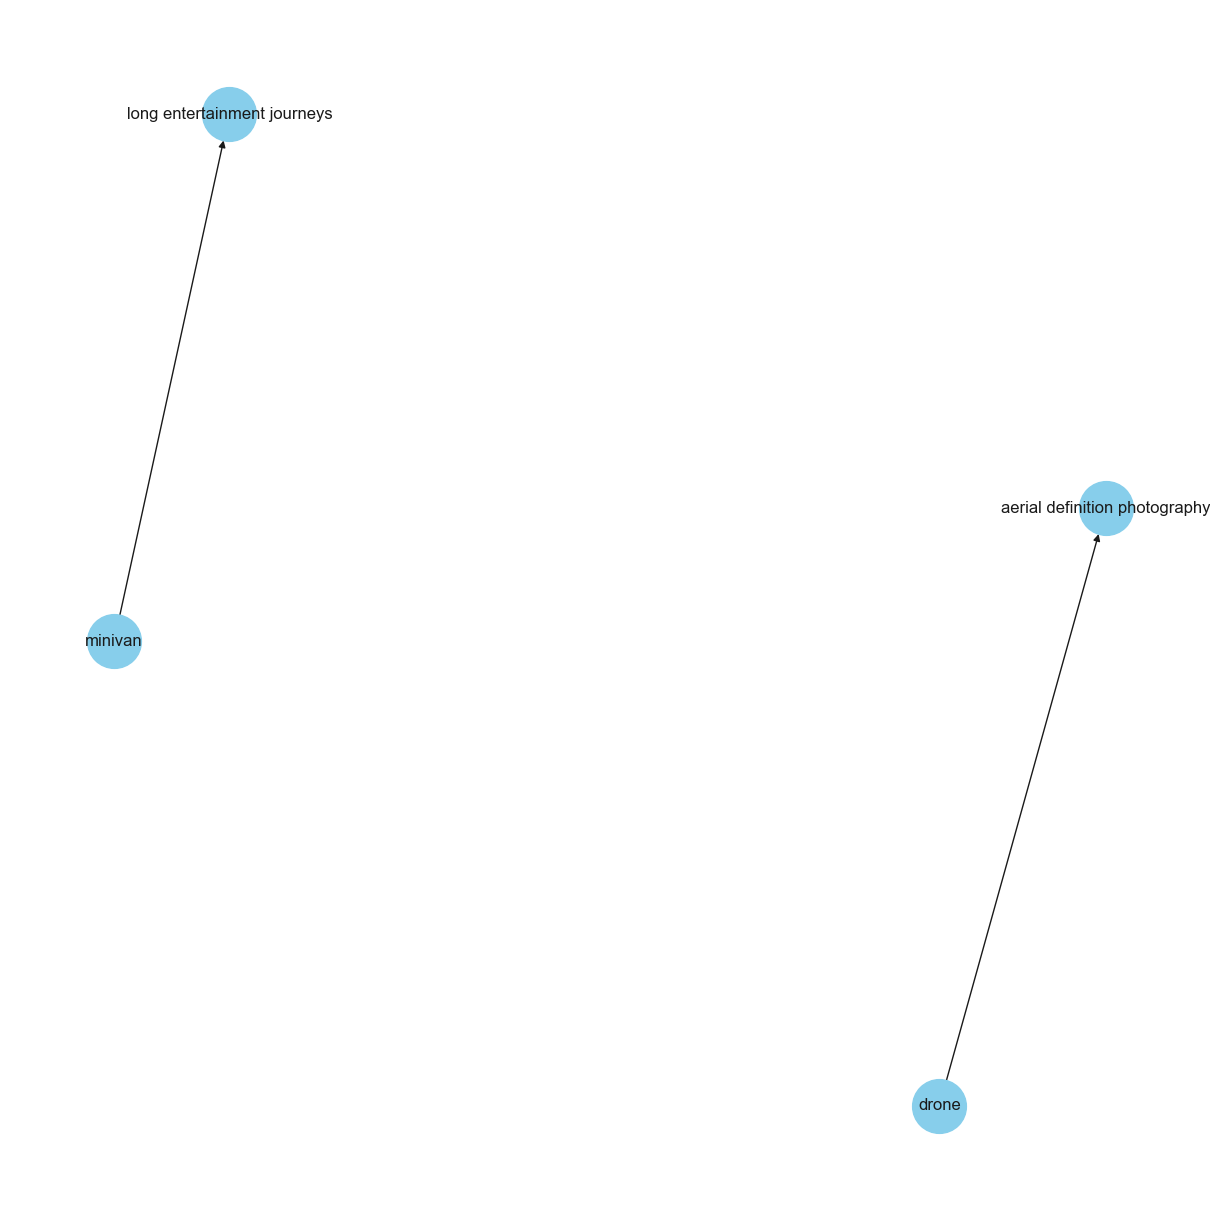

In [15]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="equipped with"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [16]:
# Topic exploration with LDA

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')  # punkt is a pre-trained model that helps you tokenize words and sentences.
nltk.download('wordnet') # wordnet is a lexical database for the English language that helps the script determine the base word.
nltk.download('stopwords') # stopwords are common words that carry less important meaning than keywords.


# Tokenize words, remove stopwordw, lemmatize, convert to the bag of words. 

def preprocess(df):
    corpus = [] # Create a list to store the words
    stem = nltk.PorterStemmer() # Create a stem object 
    lem = nltk.WordNetLemmatizer() # Create a lemmatizer object
    for sentence in df['sentence']:
        words = [w for w in word_tokenize(sentence) if (w not in stopwords.words("english")) & (w.isalpha())]
        words = [lem.lemmatize(w) for w in words]
        corpus.append(words)
    return corpus    

corpus = preprocess(df)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pablo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pablo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pablo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
# Create the bag of words
import gensim
from gensim import corpora
dictionary = corpora.Dictionary(corpus)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in corpus]

In [18]:
lda_model = gensim.models.LdaMulticore(doc_term_matrix,
                                   num_topics = 4,
                                   id2word = dictionary,
                                   passes = 10,
                                   workers = 2)
lda_model.show_topics()

[(0,
  '0.094*"The" + 0.012*"color" + 0.012*"making" + 0.010*"pattern" + 0.010*"blue" + 0.007*"plant" + 0.007*"leaf" + 0.007*"black" + 0.007*"story" + 0.005*"touch"'),
 (1,
  '0.078*"The" + 0.011*"like" + 0.011*"small" + 0.010*"capturing" + 0.007*"made" + 0.007*"seemed" + 0.007*"young" + 0.007*"complex" + 0.007*"architecture" + 0.007*"making"'),
 (2,
  '0.068*"The" + 0.013*"could" + 0.013*"required" + 0.009*"unique" + 0.009*"seemed" + 0.009*"car" + 0.009*"hue" + 0.009*"formed" + 0.009*"small" + 0.009*"head"'),
 (3,
  '0.066*"The" + 0.013*"making" + 0.013*"could" + 0.009*"blue" + 0.009*"instrument" + 0.005*"size" + 0.005*"easily" + 0.005*"ocean" + 0.005*"garden" + 0.005*"unique"')]

In [19]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.101309  0.014946       1        1  39.742229
1     -0.072650  0.071704       2        1  24.770143
2     -0.046650 -0.081279       3        1  18.356978
3      0.017991 -0.005370       4        1  17.130650, topic_info=          Term      Freq     Total Category  logprob  loglift
29       could  4.000000  4.000000  Default  30.0000  30.0000
19    required  2.000000  2.000000  Default  29.0000  29.0000
33       small  3.000000  3.000000  Default  28.0000  28.0000
169  capturing  2.000000  2.000000  Default  27.0000  27.0000
226       blue  4.000000  4.000000  Default  26.0000  26.0000
..         ...       ...       ...      ...      ...      ...
211  intricate  0.654423  2.469002   Topic4  -5.2758   0.4365
208        art  0.654421  2.469003   Topic4  -5.2758   0.4365
290    vibrant  0.654358  1.705964   Topic4  -5.2759   0.8061
25         sky  0.654135  2.469083   Topic4  -5.2762   0.4360
140     looked  0.654006  2.469120   Topic4  -5.2764   0.4358

[237 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
58        4  0.902326  Aboriginal
175       1  0.536721    Compared
175       2  0.536721    Compared
0         1  0.463921         The
0         2  0.248529         The
...     ...       ...         ...
214       4  0.902326        wood
294       1  1.027800        work
174       2  0.580926      yellow
174       3  0.580926      yellow
126       2  0.561609       young

[261 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

## Topic Modelling

The sentences seems as description of objects or actions. Therefore, our purpose is to classify the sentences into topics and then classify the positivity or negativity of the sentences.

For this purpose, first we will create some words embeddings of the object of description using word2vec. Since word2vec create a vector representation of the word based on the semantic meaning of the word, we can use this representation to classify the sentences into topics. With the embeddings, we can use clustering algorithms to group the sentences which refer to objects of the same topic, and then label the clusters with the top word of the semantic field.




In [ ]:
# Function to extract subject and object relations from sentences
def get_entities(sent):
    ## Chunk 1
    ent1 = "" # Subject
    ent2 = "" # Object
    
    prv_tok_dep = ""    # Dependency tag of previous token in the sentence
    prv_tok_text = ""   # Previous token in the sentence
    
    prefix = "" # Prefix of the dependency tag
    modifier = "" # Modifier of the dependency tag
    
    for tok in nlp(sent):
        ## Chunk 2
        # Check if token is a punctuation mark, if yes, ignore it
        if tok.dep_ != "punct":
            # Check if token is a compound word
            if tok.dep_ == "compound":
                prefix = tok.text
                # If the previous word was also a 'compound' word, add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " "+ tok.text
        
            # Check if token is a modifier
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # If the previous word was also a 'compound' word, add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " "+ tok.text
            
            ## Chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier +" "+ prefix + " "+ tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""
            
            ## Chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = modifier +" "+ prefix +" "+ tok.text
            
            ## Chunk 5
            # Update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
            
    return [ent1.strip(), ent2.strip()]


In [98]:
from nltk.stem.wordnet import WordNetLemmatizer
from spacy.lang.en import English

SUBJECTS = ["nsubj", "nsubjpass", "csubj", "csubjpass", "agent", "expl"]
OBJECTS = ["dobj", "dative", "attr", "oprd"]
ADJECTIVES = ["acomp", "advcl", "advmod", "amod", "appos", "nn", "nmod", "ccomp", "complm", "hmod", "infmod", "xcomp",
              "rcmod", "poss", " possessive"]
COMPOUNDS = ["compound"]
PREPOSITIONS = ["prep"]


def getSubsFromConjunctions(subs):
    moreSubs = []
    for sub in subs:
        # rights is a generator
        rights = list(sub.rights)
        rightDeps = {tok.lower_ for tok in rights}
        if "and" in rightDeps:
            moreSubs.extend([tok for tok in rights if tok.dep_ in SUBJECTS or tok.pos_ == "NOUN"])
            if len(moreSubs) > 0:
                moreSubs.extend(getSubsFromConjunctions(moreSubs))
    return moreSubs


def getObjsFromConjunctions(objs):
    moreObjs = []
    for obj in objs:
        # rights is a generator
        rights = list(obj.rights)
        rightDeps = {tok.lower_ for tok in rights}
        if "and" in rightDeps:
            moreObjs.extend([tok for tok in rights if tok.dep_ in OBJECTS or tok.pos_ == "NOUN"])
            if len(moreObjs) > 0:
                moreObjs.extend(getObjsFromConjunctions(moreObjs))
    return moreObjs


def getVerbsFromConjunctions(verbs):
    moreVerbs = []
    for verb in verbs:
        rightDeps = {tok.lower_ for tok in verb.rights}
        if "and" in rightDeps:
            moreVerbs.extend([tok for tok in verb.rights if tok.pos_ == "VERB"])
            if len(moreVerbs) > 0:
                moreVerbs.extend(getVerbsFromConjunctions(moreVerbs))
    return moreVerbs


def findSubs(tok):
    head = tok.head
    while head.pos_ != "VERB" and head.pos_ != "NOUN" and head.head != head:
        head = head.head
    if head.pos_ == "VERB":
        subs = [tok for tok in head.lefts if tok.dep_ == "SUB"]
        if len(subs) > 0:
            verbNegated = isNegated(head)
            subs.extend(getSubsFromConjunctions(subs))
            return subs, verbNegated
        elif head.head != head:
            return findSubs(head)
    elif head.pos_ == "NOUN":
        return [head], isNegated(tok)
    return [], False


def isNegated(tok):
    negations = {"no", "not", "n't", "never", "none"}
    for dep in list(tok.lefts) + list(tok.rights):
        if dep.lower_ in negations:
            return True
    return False


def findSVs(tokens):
    svs = []
    verbs = [tok for tok in tokens if tok.pos_ == "VERB"]
    for v in verbs:
        subs, verbNegated = getAllSubs(v)
        if len(subs) > 0:
            for sub in subs:
                svs.append((sub.orth_, "!" + v.orth_ if verbNegated else v.orth_))
    return svs


def getObjsFromPrepositions(deps):
    objs = []
    for dep in deps:
        if dep.pos_ == "ADP" and dep.dep_ == "prep":
            objs.extend(
                [tok for tok in dep.rights if tok.dep_ in OBJECTS or (tok.pos_ == "PRON" and tok.lower_ == "me")])
    return objs


def getAdjectives(toks):
    toks_with_adjectives = []
    for tok in toks:
        adjs = [left for left in tok.lefts if left.dep_ in ADJECTIVES]
        adjs.append(tok)
        adjs.extend([right for right in tok.rights if tok.dep_ in ADJECTIVES])
        tok_with_adj = " ".join([adj.lower_ for adj in adjs])
        toks_with_adjectives.extend(adjs)

    return toks_with_adjectives


def getObjsFromAttrs(deps):
    for dep in deps:
        if dep.pos_ == "NOUN" and dep.dep_ == "attr":
            verbs = [tok for tok in dep.rights if tok.pos_ == "VERB"]
            if len(verbs) > 0:
                for v in verbs:
                    rights = list(v.rights)
                    objs = [tok for tok in rights if tok.dep_ in OBJECTS]
                    objs.extend(getObjsFromPrepositions(rights))
                    if len(objs) > 0:
                        return v, objs
    return None, None


def getObjFromXComp(deps):
    for dep in deps:
        if dep.pos_ == "VERB" and dep.dep_ == "xcomp":
            v = dep
            rights = list(v.rights)
            objs = [tok for tok in rights if tok.dep_ in OBJECTS]
            objs.extend(getObjsFromPrepositions(rights))
            if len(objs) > 0:
                return v, objs
    return None, None


def getAllSubs(v):
    verbNegated = isNegated(v)
    subs = [tok for tok in v.lefts if tok.dep_ in SUBJECTS and tok.pos_ != "DET"]
    if len(subs) > 0:
        subs.extend(getSubsFromConjunctions(subs))
    else:
        foundSubs, verbNegated = findSubs(v)
        subs.extend(foundSubs)
    return subs, verbNegated


def getAllObjs(v):
    # rights is a generator
    rights = list(v.rights)
    objs = [tok for tok in rights if tok.dep_ in OBJECTS]
    objs.extend(getObjsFromPrepositions(rights))

    potentialNewVerb, potentialNewObjs = getObjFromXComp(rights)
    if potentialNewVerb is not None and potentialNewObjs is not None and len(potentialNewObjs) > 0:
        objs.extend(potentialNewObjs)
        v = potentialNewVerb
    if len(objs) > 0:
        objs.extend(getObjsFromConjunctions(objs))
    return v, objs


def getAllObjsWithAdjectives(v):
    # rights is a generator
    rights = list(v.rights)
    objs = [tok for tok in rights if tok.dep_ in OBJECTS]

    if len(objs) == 0:
        objs = [tok for tok in rights if tok.dep_ in ADJECTIVES]

    objs.extend(getObjsFromPrepositions(rights))

    potentialNewVerb, potentialNewObjs = getObjFromXComp(rights)
    if potentialNewVerb is not None and potentialNewObjs is not None and len(potentialNewObjs) > 0:
        objs.extend(potentialNewObjs)
        v = potentialNewVerb
    if len(objs) > 0:
        objs.extend(getObjsFromConjunctions(objs))
    return v, objs


def findSVAOs(tokens):
    svos = []
    verbs = [tok for tok in tokens if tok.pos_ == "VERB" or tok.dep_ != "aux"]

    for v in verbs:
        subs, verbNegated = getAllSubs(v)
        # hopefully there are subs, if not, don't examine this verb any longer
        if len(subs) > 0:
            v, objs = getAllObjsWithAdjectives(v)
            for sub in subs:
                for obj in objs:
                    objNegated = isNegated(obj)
                    obj_desc_tokens = generate_left_right_adjectives(obj)
                    sub_compound = generate_sub_compound(sub)
                    svos.append((" ".join(tok.lower_ for tok in sub_compound),
                                 "!" + v.lower_ if verbNegated or objNegated else v.lower_,
                                 " ".join(tok.lower_ for tok in obj_desc_tokens)))
    return svos


def generate_sub_compound(sub):
    sub_compunds = []
    for tok in sub.lefts:
        if tok.dep_ in COMPOUNDS:
            sub_compunds.extend(generate_sub_compound(tok))
    sub_compunds.append(sub)
    for tok in sub.rights:
        if tok.dep_ in COMPOUNDS:
            sub_compunds.extend(generate_sub_compound(tok))
    return sub_compunds


def generate_left_right_adjectives(obj):
    obj_desc_tokens = []
    for tok in obj.lefts:
        if tok.dep_ in ADJECTIVES:
            obj_desc_tokens.extend(generate_left_right_adjectives(tok))
    obj_desc_tokens.append(obj)

    for tok in obj.rights:
        if tok.dep_ in ADJECTIVES:
            obj_desc_tokens.extend(generate_left_right_adjectives(tok))

    return obj_desc_tokens

            

In [103]:
import spacy
nlp = spacy.load('en_core_web_md')

def extract_subject(sentence):
    tokens = nlp(sentence)
    svos = findSVAOs(tokens)
    return svos[0][0]

In [110]:
for sentence in sentences:
    token = nlp(sentence)
    keywords = []
    for chunk in token.noun_chunks:
        if chunk.text.lower() not in nlp.Defaults.stop_words:
            keywords.append(chunk.text)
    print(keywords)

["The dragonfly's wings", 'gemstones', 'the sunlight']
['The bagpipes', 'a tartan pattern', 'Scottish tradition']
['The fur pattern', 'the tiger']
['The triangle', 'simple but required precise timing']
['The sequoia tree', 'the sky']
['The microchip', 'the skin']
['The mimosa plant', 'its leaves']
['The porcupine', 'quills']
['The dandelion seed head', 'a delicate sphere', 'the wind']
['The origami crane']
['The didgeridoo', 'a haunting sound', 'Aboriginal culture']
['The virtual reality headset', 'an immersive experience']
['The petals', 'the rose', 'perfect symmetry']
['The pickup truck', 'a toolbox', 'a rack', 'lumber']
["The dolphin's streamlined shape", 'water']
['The octopus', 'remarkable intelligence', 'puzzles']
['The length', 'the train', 'the horizon']
['The tuba', 'its own seat', 'the orchestra']
["The sitar's complex architecture"]
['The carnivorous pitcher plant', 'insects', 'its deadly trap']
['The quilt', 'a kaleidoscope', 'colors', 'each patch', 'its own story']
['The k

In [114]:
# Type of the sentence
def get_type(sentence):
    doc = nlp(sentence)
    for token in doc:
        print(token.text, "-->", token.dep_, "-->", token.head.text)
        
for sentence in sentences:
    get_type(sentence)
        

The --> det --> dragonfly
dragonfly --> poss --> wings
's --> case --> dragonfly
wings --> nsubj --> sparkled
sparkled --> ROOT --> sparkled
like --> prep --> sparkled
gemstones --> pobj --> like
in --> prep --> sparkled
the --> det --> sunlight
sunlight --> pobj --> in
. --> punct --> sparkled
The --> det --> bagpipes
bagpipes --> nsubjpass --> adorned
were --> auxpass --> adorned
adorned --> ROOT --> adorned
with --> prep --> adorned
a --> det --> pattern
tartan --> compound --> pattern
pattern --> pobj --> with
, --> punct --> pattern
honoring --> acl --> pattern
Scottish --> amod --> tradition
tradition --> dobj --> honoring
. --> punct --> adorned
The --> det --> pattern
fur --> compound --> pattern
pattern --> nsubj --> striking
on --> prep --> pattern
the --> det --> tiger
tiger --> pobj --> on
was --> aux --> striking
striking --> ROOT --> striking
and --> cc --> striking
intimidating --> conj --> striking
. --> punct --> striking
The --> det --> triangle
triangle --> nsubj -->

In [105]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-mpnet-base-v2')   

#Generate sentence embeddings of the subjects of the sentences
subjects = [extract_subject(sentence) for sentence in sentences]
subject_embeddings = model.encode(subjects) 

IndexError: list index out of range

In [76]:
print(subject_embeddings.shape)

(100, 768)


In [77]:
# Clustering

from sklearn.cluster import DBSCAN

dbscan_model = DBSCAN(eps=0.5, min_samples=2, metric = 'cosine')
labels = dbscan_model.fit_predict(subject_embeddings)

# Step 3: Organize and Name Clusters (Optional)
clusters = {}
for i, label in enumerate(labels):
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(subjects[i])

# Display clusters
for label, items in clusters.items():
    print(f"Cluster {label}: {items}")

Cluster 0: ['wings', 'other  wingspan']
Cluster 1: ['bagpipes', 'violin', 'harmonica', 'electric  it', 'flute', 'grand  piano', 'electric  guitar']
Cluster -1: ['fur pattern', 'triangle', 'so sequoia it', 'seed head', 'origami crane', 'haunting  that', 'virtual reality headset', 'carnivorous pitcher plant', 'quilt', 'kangaroo', 'long  tongue', 'spacecraft', 'wherever luxury it', 'school bus', 'stained glass that', 'so drum it', 'often  it', 'red  leaves', 'deep  it', 'aerodynamic sports that', 'Venus flytrap', 'peacock', 'elaborate  that', 'vintage scooter', '', 'chameleon', 'retractable  that', 'coffee it', 'hand  each', 'black  stripes', 'ivy', 'computer code', 'fountain', 'bamboo stalks', 'spines', 'intricate  veins']
Cluster 2: ['so  it', 'so  it', 'it', 'so  it', 'so  they', 'so  it', 'it', 'so fire it', 'entire  it', 'so  it', 'so  it', 'it']
Cluster 3: ['mimosa plant', 'petals', 'vera plant', 'cherry blossoms', 'lavender', 'lotus flower', 'pumpkin vine', 'sunflower', 'fireworks'

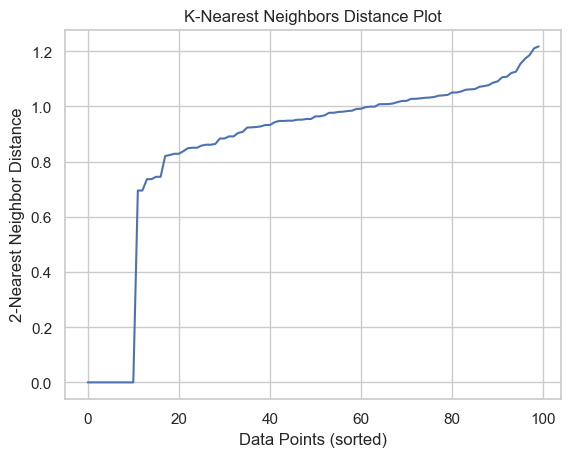

In [71]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
# Use the embeddings you already generated
X = subject_embeddings  # Replace with your embeddings

# Set min_samples for DBSCAN and use it as k in KNN
min_samples = 2  # This value should align with the DBSCAN `min_samples` parameter

# Fit NearestNeighbors with k set to min_samples
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Sort distances to get the kth nearest distance for each point
distances = np.sort(distances[:, min_samples - 1], axis=0)

# Plot the distances
plt.plot(distances)
plt.xlabel("Data Points (sorted)")
plt.ylabel(f"{min_samples}-Nearest Neighbor Distance")
plt.title("K-Nearest Neighbors Distance Plot")
plt.show()

In [80]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Try different eps values and evaluate
eps_values = np.arange(0.05, 1, 0.05)  # Adjust the range and step based on your data
best_eps = None
best_score = -1

for eps in eps_values:
    dbscan_model = DBSCAN(eps=eps, min_samples=min_samples, metric="cosine")
    labels = dbscan_model.fit_predict(X)

    # Filter out noise points (label -1)
    if len(set(labels)) > 1:  # More than one cluster
        # Calculate the silhouette score (ignores noise by default)
        score = silhouette_score(X, labels)
        print(f"eps: {eps:.2f}, clusters: {len(set(labels)) - (1 if -1 in labels else 0)}, silhouette score: {score:.3f}")

        # Track the best eps based on silhouette score
        if score > best_score:
            best_eps = eps
            best_score = score

print(f"Best eps based on silhouette score: {best_eps}, with score: {best_score}")


eps: 0.05, clusters: 3, silhouette score: 0.070
eps: 0.10, clusters: 3, silhouette score: 0.070
eps: 0.15, clusters: 3, silhouette score: 0.070
eps: 0.20, clusters: 3, silhouette score: 0.070
eps: 0.25, clusters: 4, silhouette score: 0.069
eps: 0.30, clusters: 6, silhouette score: 0.057
eps: 0.35, clusters: 7, silhouette score: 0.056
eps: 0.40, clusters: 10, silhouette score: 0.031
eps: 0.45, clusters: 13, silhouette score: 0.058
eps: 0.50, clusters: 14, silhouette score: 0.071
eps: 0.55, clusters: 8, silhouette score: 0.030
eps: 0.60, clusters: 1, silhouette score: 0.027
eps: 0.65, clusters: 1, silhouette score: 0.034
eps: 0.70, clusters: 1, silhouette score: 0.040
Best eps based on silhouette score: 0.5, with score: 0.07134239375591278


In [85]:
#eps = best_eps

#dbscan_model = DBSCAN(eps=eps, min_samples=min_samples, metric = "cosine")  
#labels = dbscan_model.fit_predict(X)

from sklearn.cluster import OPTICS

optics_model = OPTICS(min_samples=2, metric='cosine', cluster_method="xi", xi=0.05)
labels = optics_model.fit_predict(subject_embeddings)

# Step 3: Organize and Name Clusters (Optional)
clusters = {}
for i, label in enumerate(labels):
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(subjects[i])
    
# Display clusters
for label, items in clusters.items():
    print(f"Cluster {label}: {items}")


Cluster 0: ['wings', 'other  wingspan']
Cluster 16: ['bagpipes', 'violin', 'harmonica', 'flute', 'grand  piano']
Cluster -1: ['fur pattern', 'triangle', 'so sequoia it', 'mimosa plant', 'seed head', 'origami crane', 'haunting  that', 'virtual reality headset', 'carnivorous pitcher plant', 'quilt', 'vera plant', 'spacecraft', 'wherever luxury it', 'golden  that', 'stained glass that', 'lavender', 'so drum it', 'often  it', 'pumpkin vine', 'deep  it', 'layout', 'Venus flytrap', 'peacock', 'elaborate  that', 'vintage scooter', '', 'chameleon', 'retractable  that', 'coffee it', 'so fire it', 'entire  it', 'hand  each', 'fireworks', 'black  stripes', 'ivy', 'computer code', 'bonsai', 'fountain', 'bamboo stalks', 'spines', 'intricate  veins']
Cluster 8: ['so  it', 'so  it', 'so  it', 'so  they', 'so  it', 'so  it', 'so  it']
Cluster 6: ['that', 'mother  that']
Cluster 1: ['petals', 'cherry blossoms', 'lotus flower', 'sunflower']
Cluster 14: ['pickup truck', 'school bus', 'compact  sedan', 'a

C:\Users\pablo\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_optics.py:995: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [84]:
from sklearn.mixture import GaussianMixture

gmm_model = GaussianMixture(n_components=15, covariance_type='tied')
gmm_labels = gmm_model.fit_predict(subject_embeddings)

# Step 3: Organize and Name Clusters (Optional)
clusters = {}
for i, label in enumerate(gmm_labels):
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(subjects[i])

# Display clusters
for label, items in clusters.items():
    print(f"Cluster {label}: {items}")

Cluster 8: ['wings', 'length', 'long  tongue', 'other  wingspan']
Cluster 0: ['bagpipes', 'violin', 'harmonica', 'flute', 'grand  piano', 'electric  guitar']
Cluster 14: ['fur pattern', 'quilt', 'intricate wood it']
Cluster 3: ['triangle', 'mimosa plant', 'octopus', 'carnivorous pitcher plant', 'vera plant', 'bamboo stalks', 'cactus', 'spines']
Cluster 4: ['so sequoia it', 'so  it', 'so  it', 'so drum it', 'so  it', 'so  they', 'so  it', 'so fire it', 'so  it', 'so  it']
Cluster 6: ['that', 'haunting  that', 'golden  that', 'stained glass that', 'ornate  that', 'mother  that', 'elaborate  that', 'retractable  that']
Cluster 1: ['seed head', 'petals', 'cherry blossoms', 'lavender', 'lotus flower', 'pumpkin vine', 'sunflower', 'ivy', 'bonsai']
Cluster 10: ['origami crane', 'kangaroo', 'Venus flytrap', 'peacock', 'chameleon', 'platypus', 'hamster', 'fountain']
Cluster 7: ['virtual reality headset', 'spacecraft', 'robot', 'fireworks', 'drone', 'army tank']
Cluster 13: ['pickup truck', 'sch

In [95]:
!python -m spacy download en_core_web_md 

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/33.5 MB ? eta -:--:--
     --- ------------------------------------ 3.1/33.5 MB 20.6 MB/s eta 0:00:02
     ---------- ----------------------------- 9.2/33.5 MB 26.0 MB/s eta 0:00:01
     -------------------- ------------------ 17.6/33.5 MB 29.9 MB/s eta 0:00:01
     ----------------------------- --------- 25.2/33.5 MB 31.2 MB/s eta 0:00:01
     --------------------------------------  33.3/33.5 MB 34.1 MB/s eta 0:00:01
     --------------------------------------- 33.5/33.5 MB 31.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


[('didgeridoo', 'produced', 'haunting sound')]


In [97]:
parse = sentences[10]
print(findSVAOs(parse))
print(sentences[10])

AttributeError: 'str' object has no attribute 'pos_'